# Political Alignment Case Study

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

### Setup

If you are running this notebook in Colab, the following cell downloads the `empiricaldist` library.

If you are running in another environment, you will need to install it yourself.

In [1]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [4]:
# Load some utility code

file = 'utils.py'
if not os.path.exists(file):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/utils.py

If everything we need is installed, the following cell should run without error.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Cdf

The following cell defines a function I use to decorate the axes in plots.

In [3]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

### Loading the data

In the previous notebook, we downloaded GSS data, loaded and cleaned it, resampled it to correct for stratified sampling, and then saved the data in an HDF5 file, which is much faster to load.  In this and the following notebooks, we'll download the HDF5 file and load it.

The following cell downloads the file.

In [4]:
# Load the data file

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5


This file contains three DataFrames containing resamples of the GSS data.  We'll work with the first resampling, `gss0`, to get started; at the end of this notebook, we'll see the other two as well.

In [5]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 120)

In [6]:
def prepare_df(df):
    df['y2'] = (df['year']-2004)**2
    df['c2'] = (df['cohort']-1970)**2
    df['christian'] = df['relig'].isin([1,2,11])
    df['none'] = (df['relig'] == 4)
    recent = (df['year'] >= 2004)
    notold = (df['cohort'] >= 1940)
    return df[recent & notold]

In [7]:
df = prepare_df(gss)
df.shape

(18661, 124)

In [8]:
from utils import resample_rows_weighted

dfs = None
dfs = [resample_rows_weighted(df, df['wtssall'])
       for i in range(101)]

As in the previous notebook, we'll use `values` to plot the values in the series and their frequencies.

In [9]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

In [10]:
christian = df[df['christian']].copy()
christian.shape

(13828, 124)

In [11]:
none = df[df['none']].copy()
none.shape

(3718, 124)

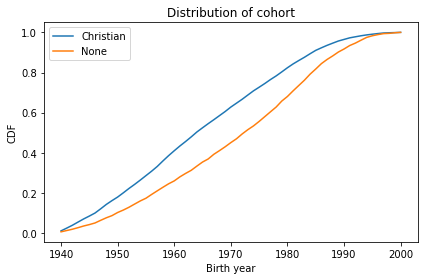

In [13]:
age_c = Cdf.from_seq(christian['cohort'])
age_n = Cdf.from_seq(none['cohort'])

age_c.plot(label='Christian')
age_n.plot(label='None')

decorate(xlabel='Birth year',
         ylabel='CDF',
         title='Distribution of cohort')

plt.legend();

In [14]:
varname = 'nateduc'
value = 1

valid = christian.dropna(subset=[varname]).copy()
valid.shape

(6383, 124)

In [15]:
(valid[varname] == 1).mean()

0.7256775810747298

In [16]:
valid['y'] = (valid[varname] == value).astype(int)
valid['y'].value_counts()

1    4632
0    1751
Name: y, dtype: int64

In [17]:
series = valid.groupby('year')['y'].mean()
series

year
2004    0.726073
2006    0.747624
2008    0.713396
2010    0.731343
2012    0.724615
2014    0.709599
2016    0.704522
2018    0.747155
Name: y, dtype: float64

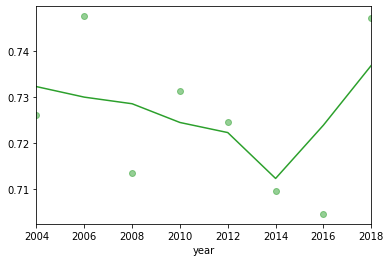

In [18]:
from utils import plot_series_lowess

plot_series_lowess(series, 'C2')

In [19]:
valid['cohort'].isna().sum()

0

In [20]:
series = valid.groupby('cohort')['y'].mean()
series

cohort
1940.0    0.625000
1941.0    0.702381
1942.0    0.616279
1943.0    0.575758
1944.0    0.617978
            ...   
1996.0    0.666667
1997.0    0.652174
1998.0    0.727273
1999.0    0.750000
2000.0    0.727273
Name: y, Length: 61, dtype: float64

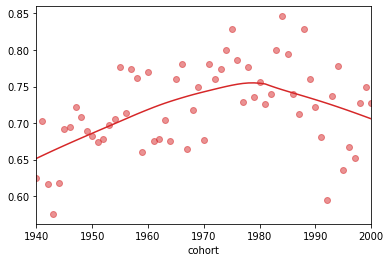

In [21]:
plot_series_lowess(series, 'C3')

In [22]:
import statsmodels.formula.api as smf

In [23]:
formula = ('y ~ year + cohort')
model = smf.logit(formula, data=valid).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.585527
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6383
Model:                          Logit   Df Residuals:                     6380
Method:                           MLE   Df Model:                            2
Date:                Tue, 31 Dec 2019   Pseudo R-squ.:                0.003377
Time:                        09:39:51   Log-Likelihood:                -3737.4
converged:                       True   LL-Null:                       -3750.1
Covariance Type:            nonrobust   LLR p-value:                 3.165e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1454     11.989      0.012      0.990     -23.353      23.644
year          -0.0092      0.006     -1.537      0.124      -0.021       0.003
cohort         0.0098      0.002      4.977      0.000       0.006       0.014
==============================================================================
"""

In [24]:
formula = ('y ~ year + y2 + cohort + c2')
model = smf.logit(formula, data=valid).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.584696
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6383
Model:                          Logit   Df Residuals:                     6378
Method:                           MLE   Df Model:                            4
Date:                Tue, 31 Dec 2019   Pseudo R-squ.:                0.004791
Time:                        09:39:52   Log-Likelihood:                -3732.1
converged:                       True   LL-Null:                       -3750.1
Covariance Type:            nonrobust   LLR p-value:                 2.985e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.7520     45.072      0.993      0.321     -43.588     133.092
year          -0.0285      0.022     -1.272      0.204      -0.072       0.015
y2             0.0016      0.002      1.041      0.298      -0.001       0.005
cohort         0.0069      0.002      3.199      0.001       0.003       0.011
c2            -0.0004      0.000     -3.149      0.002      -0.001      -0.000
==============================================================================
"""

In [25]:
model.nobs

6383

In [26]:
model.params

Intercept    44.751994
year         -0.028501
y2            0.001630
cohort        0.006877
c2           -0.000409
dtype: float64

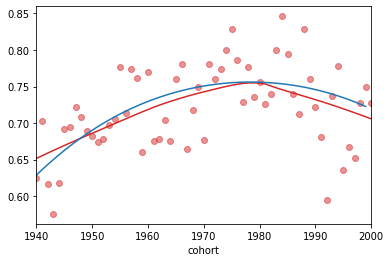

In [27]:
xs = np.arange(1940, 2000)

df_pred = pd.DataFrame()
df_pred['cohort'] = xs
df_pred['year'] = 2018
df_pred['y2'] = (df_pred['year']-2004)**2
df_pred['c2'] = (df_pred['cohort']-1970)**2

plot_series_lowess(series, 'C3')
ys = model.predict(df_pred)
plt.plot(xs, ys)

In [28]:
df_pred = pd.DataFrame()
df_pred['cohort'] = [1960, 1995]
df_pred['year'] = 2018
df_pred['y2'] = (df_pred['year']-2004)**2
df_pred['c2'] = (df_pred['cohort']-1970)**2
df_pred

,cohort,year,y2,c2
0,1960,2018,196,100
1,1995,2018,196,625


In [29]:
model.predict(df_pred)

0    0.729660
1    0.734733
dtype: float64

In [30]:
def run_model(df, varname, value):
    value = np.atleast_1d(value)
    valid = df.dropna(subset=[varname]).copy()
    valid['y'] = (valid[varname].isin(value)).astype(int)
    formula = ('y ~ year + cohort')
    model = smf.logit(formula, data=valid).fit(disp=0)
    res = model.predict(df_pred)
    return res.values

In [31]:
def run_model2(df, varname, value):
    value = np.atleast_1d(value)
    valid = df.dropna(subset=[varname]).copy()
    valid['y'] = (valid[varname].isin(value)).astype(int)
    formula = ('y ~ year + y2 + cohort + c2')
    model = smf.logit(formula, data=valid).fit(disp=0)
    res = model.predict(df_pred)
    return res.values

In [32]:
run_model(christian, varname, value)

array([0.70142935, 0.76827921])

In [33]:
run_model(none, varname, value)

array([0.80413029, 0.84289712])

In [34]:
def compare(df, varname, value):
    christian = df[df['christian']]
    none = df[df['none']]

    c = run_model(christian, varname, value)
    n = run_model(none, varname, value)
    return np.hstack([c, n]) * 100

In [35]:
compare(df, varname, value)

array([70.1429352 , 76.82792144, 80.41302898, 84.28971184])

In [36]:
def compare_iter(dfs, varname, value):
    t = [compare(df, varname, value) for df in dfs]
    a = np.array(t)
    percentiles = np.percentile(a, [5, 50, 95], axis=0)
    return percentiles

In [37]:
percentiles = compare_iter(dfs, varname, value)
percentiles

array([[67.65481952, 74.70890313, 76.47861966, 80.20045496],
       [69.70142949, 76.70064587, 80.02338835, 83.03432998],
       [71.79433104, 79.22420819, 83.62220971, 85.47877336]])

In [38]:
def plot_interval(y, interval, dy=0.3, **options):
    low, mid, high = interval
    plt.hlines(y+dy, low, high, alpha=0.6, **options)
    plt.vlines([low, high], y+dy, y+dy/2, alpha=0.6, **options)

In [39]:
color_map = {'Christian':'C0',
             'None':'C1'}

def plot_arrow(y, row, group):
    color = color_map[group]
    label1 = f'{group} born 1960'
    label2 = f'{group} born 1995'
    
    x1, x2 = row    
    dx = x2 - x1
    plt.hlines(y, x1, x2, color=color, alpha=0.3)
    
    plt.plot(x1, y, 'o', color=color, label=label1)
    
    style = '>' if x2 > x1 else '<'
    plt.plot(x2, y, style, color=color, label=label2)

In [40]:
def plot_percentiles(y, percentiles, dy=-0.05):
    plot_interval(y, percentiles[:, 2], color='C1')
    plot_arrow(y, percentiles[1, 2:4], group='None')
    plot_interval(y+dy, percentiles[:, 0], color='C0')
    plot_arrow(y+dy, percentiles[1, 0:2], group='Christian')

In [41]:
def miniplot(percentiles):
    plot_percentiles(0, percentiles)
    plt.ylim(-2.5, 2)
    plt.gca().invert_yaxis()

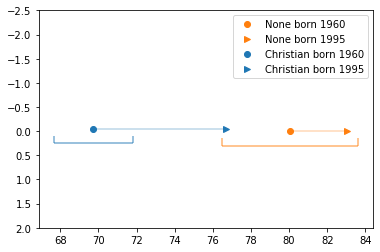

In [42]:
miniplot(percentiles)
plt.legend()

There are always some people whose ideas are considered bad or dangerous by other people. 

* libath: For instance, somebody who is against all churches and religion . . .
If some people in your community suggested that a book he wrote against churches and religion should be taken out of your public library, would you favor removing this book, or not?

* librac: Or consider a person who believes that Blacks are genetically inferior.
If some people in your community suggested that a book he wrote which said Blacks are inferior should be taken out of your public library, would you favor removing this book, or not?

* libcom: Now, I should like to ask you some questions about a man who admits he is a Communist.
Suppose he wrote a book which is in your public library. Somebody in your community suggests that the book should be removed from the library. Would you favor removing it, or not?

* libmil: Consider a person who advocates doing away with elections and letting the military run the country.
Suppose he wrote a book advocating doing away with elections and letting the military run the country.  Somebody in your community suggests that the book be removed from the public library. Would you favor removing it, or not?

* libhomo: And what about a man who admits that he is a homosexual?
If some people in your community suggested that a book he wrote in favor of homosexuality should be taken out of your public library, would you favor removing this book, or not?

* libmslm: Now consider a Muslim clergyman who preaches hatred of the United States.
If some people in your community suggested that a book he wrote which preaches hatred of the United States should be taken out of your public library, would you favor removing this book, or not?

In [43]:
variables = [
    # allow to speak
    ('spkmil', 1, 'Anti-democratic\nmilitarist'),   
    ('spkmslm', 1, 'Anti-U.S.\nMuslim clergyman'),
    ('spkath', 1, 'Opponent of churches\nand religion'),
    ('spkcom', 1, 'Communist'),
    ('spkrac', 1, 'Racist'),
    ('spkhomo', 1, 'Homosexual'),

    # allow to teach at a college or university
    ('colmil', 4, 'Anti-democratic\nmilitarist'),
    ('colmslm', 4, 'Anti-U.S.\nMuslim clergyman'),
    ('colath', 4, 'Opponent of churches\nand religion'),
    ('colcom', 5, 'Communist'),    # not fired
    ('colrac', 4, 'Racist'),
    ('colhomo', 4, 'Homosexual'),

    # do not remove from library
    ('libmil', 2, 'Anti-democratic\nmilitarist'),
    ('libmslm', 2, 'Anti-U.S.\nMuslim clergyman'),
    ('libath', 2, 'Opponent of churches\nand religion'),
    ('libcom', 2, 'Communist'),
    ('librac', 2, 'Racist'),
    ('libhomo', 2, 'Homosexual'),

    ('homosex', 1, 'Same-sex relations\nalways wrong'),
    ('premarsx', 1, 'Premarital sex\nalways wrong'),
    ('xmarsex', 1, 'Extramarital sex\nalways wrong'),
    ('teensex', 1, 'Teen sex\nalways wrong'),
    ('sexeduc', 1, 'Favor sex education\nin schools'),
    
    ('abany', 1, 'Allow abortion for any reason'),
    
    ('cappun', 2, 'Favor death penalty for murder'),
    ('gunlaw', 1, 'Favor permit to buy gun'),
    ('grass', 1, 'Marijuana should be\nmade legal'),
    ('divlaw', 1, 'Divorce should be\neasier to obtain'),
    ('prayer', 1, 'Approve SCOTUS ruling\nprohibiting school prayer'),
    ('letdie1', 1, 'Allow doctor to end life\nof terminal patient'),
    ('racopen', 2, 'Favor law barring housing discrimination'),
    ('pornlaw', [2,3], 'Pornography should be legal'),
    ('affrmact', [1,2], 'Favor affirmative action\nfor blacks'),
    #('racpres', 1, ''),

    ('spanking', [1,2], 'Spanking sometimes\nnecessary'),
    ('fepol', 2, 'Agree men are emotionally\nmore suited for politics'),

    ('natspac', 1, 'Space exploration'),
    ('natenvir', 1, 'Improving and protecting\nthe environment'),
    ('natheal', 1, "Improving and protecting\nthe nation's health"),
    ('natcity', 1, 'Solving the problems of\nthe big cities'),
    ('natcrime', 1, 'Halting the rising\ncrime rate'),
    ('natdrug', 1, 'Dealing with drug addiction'),
    ('nateduc', 1, "Improving the nation's\neducation system"),
    ('natrace', 1, 'Improving the conditions\nof Blacks'),
    ('natarms', 1, 'The military, armaments\nand defense'),
    ('nataid', 1, 'Foreign aid'),
    ('natfare', 1, 'Welfare'),
    
    #('confinan', 1, 'Banks and financial instituions'),
    #('conbus', 1, 'Major companies'),
    ('conclerg', 1, 'Organized religion'),
    ('coneduc', 1, 'Education'),
    ('confed', 1, 'Executive branch of\nthe federal government'),
    #('conlabor', 1, 'Organized labor'),
    ('conpress', 1, 'Press'),
    #('conmedic', 1, 'Medicine'),
    #('contv', 1, 'Television'),
    ('conjudge', 1, 'U.S. Supreme Court'),
    #('consci', 1, 'Scientific community'),
    ('conlegis', 1, 'Congress'),
    ('conarmy', 1, 'Military'),
    
    ('helpful', 1, 'People try to be helpful'),
    ('fair', 2, 'People try to be fair'),
    ('trust', 1, 'People can be trusted'),
    ('fear', 2, 'Not afraid to walk alone at night'),
]

In [44]:
label_map = {}
value_map = {}

for varname, value, label in variables:
    value_map[varname] = value
    label_map[varname] = label

natenvir 1
[54.63903874 66.95379555 76.35021652 76.57385119]
[[51.1520813  64.87420781 70.99897144 73.17749161]
 [53.12079556 67.28124032 75.22910277 77.24798694]
 [54.67684413 69.90538427 78.28198447 79.55315152]]


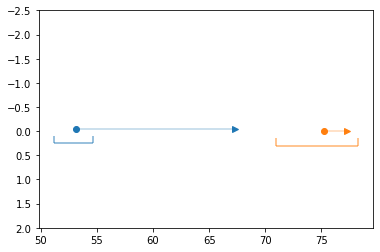

In [45]:
varname = 'natenvir'
value = value_map[varname]
print(varname, value)

res = compare(df, varname, value)
print(res)
percentiles = compare_iter(dfs, varname, value)
print(percentiles)
miniplot(percentiles)

In [46]:
for varname, value, _ in variables:
    print(varname)
    res = compare(df, varname, value)
    print(res)

spkmil
[70.41651094 77.28257239 80.56959457 78.98270045]
spkmslm
[42.92232485 39.39060139 59.66081991 53.10275909]
spkath
[77.69333454 78.86182923 89.68138536 89.22179874]
spkcom
[66.47275992 70.2766122  81.31117827 81.5670157 ]
spkrac
[59.69594289 52.92202336 67.91359742 58.53562134]
spkhomo
[88.73844392 91.5927597  93.67311959 95.4710521 ]
colmil
[56.80732507 67.09646024 65.33332853 70.08282826]
colmslm
[31.47865487 29.46612311 46.37624044 36.75409705]
colath
[61.30069085 71.48487111 76.4535299  82.53849718]
colcom
[60.41333027 70.27084407 77.76682261 78.42259757]
colrac
[45.32083497 42.7464194  50.89877214 40.85661826]
colhomo
[87.3554658  92.96203761 93.48140572 94.70283809]
libmil
[70.29368976 76.80312553 84.13354099 86.17830576]
libmslm
[46.19343578 43.2741642  66.12481763 56.8534377 ]
libath
[73.54445249 76.46759415 91.46351294 92.51135054]
libcom
[69.23360711 74.79682797 84.8393051  87.21231191]
librac
[61.694921   54.74933002 75.90661082 63.84610904]
libhomo
[80.28347303 87.61

In [47]:
def generate_results(variables):
    results = {}

    for varname, value, _ in variables:
        print(varname)
        percentiles = compare_iter(dfs, varname, value)
        results[varname] = percentiles
        
    return results

In [48]:
results = generate_results(variables)

spkmil
spkmslm
spkath
spkcom
spkrac
spkhomo
colmil
colmslm
colath
colcom
colrac
colhomo
libmil
libmslm
libath
libcom
librac
libhomo
homosex
premarsx
xmarsex
teensex
sexeduc
abany
cappun
gunlaw
grass
divlaw
prayer
letdie1
racopen
pornlaw
affrmact
spanking
fepol
natspac
natenvir
natheal
natcity
natcrime
natdrug
nateduc
natrace
natarms
nataid
natfare
conclerg
coneduc
confed
conpress
conjudge
conlegis
conarmy
helpful
fair
trust
fear


In [67]:
def multiplot(results, varnames, loc='lower left'):
    for i, varname in enumerate(varnames):
        percentiles = results[varname]
        plot_percentiles(i, percentiles)

    labels = [label_map[varname] for varname in varnames]
    plt.yticks(range(len(varnames)), labels)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:4], labels[:4], loc=loc)

    plt.gca().invert_yaxis()
    #plt.tight_layout()

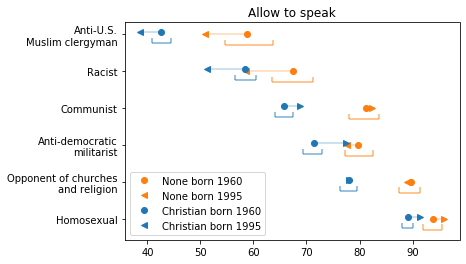

In [68]:
varnames = ['spkmslm', 'spkrac', 'spkcom', 'spkmil', 'spkath', 'spkhomo']
multiplot(results, varnames)
plt.title('Allow to speak');

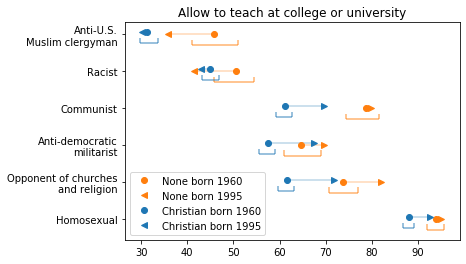

In [69]:
varnames = ['colmslm', 'colrac', 'colcom', 'colmil', 'colath', 'colhomo']
multiplot(results, varnames)
plt.title('Allow to teach at college or university');

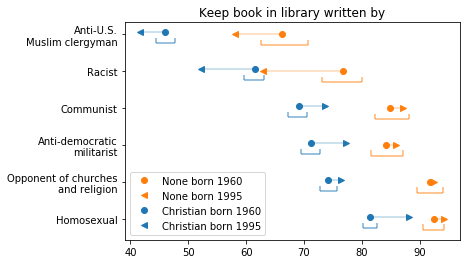

In [70]:
varnames = ['libmslm', 'librac', 'libcom', 'libmil', 'libath', 'libhomo']
multiplot(results, varnames)
plt.title('Keep book in library written by');

In [71]:
varnames = []
for varname, _, _ in variables:
    if varname.startswith('con'):
        varnames.append(varname)
        
print(varnames)

['conclerg', 'coneduc', 'confed', 'conpress', 'conjudge', 'conlegis', 'conarmy']


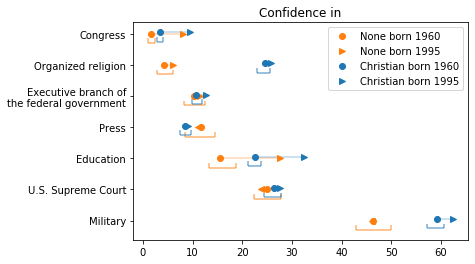

In [72]:
varnames = ['conlegis', 'conclerg', 'confed', 'conpress', 'coneduc', 'conjudge', 'conarmy']
multiplot(results, varnames, loc='upper right')
plt.title('Confidence in');

In [73]:
varnames = []
for varname, _, _ in variables:
    if varname.startswith('nat'):
        varnames.append(varname)
        
print(varnames)

['natspac', 'natenvir', 'natheal', 'natcity', 'natcrime', 'natdrug', 'nateduc', 'natrace', 'natarms', 'nataid', 'natfare']


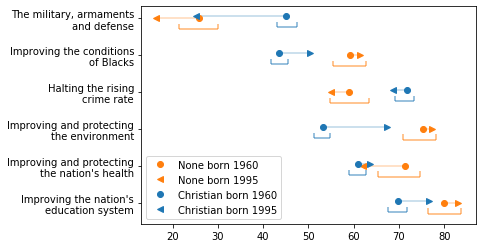

In [74]:
varnames = ['natarms', 'natrace', 'natcrime', 
            'natenvir', 'natheal', 'nateduc']
multiplot(results, varnames)

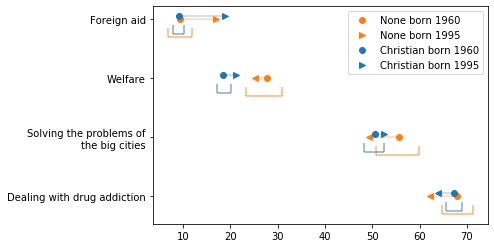

In [76]:
varnames = ['nataid', 'natfare', 'natcity', 'natdrug']
multiplot(results, varnames, loc='upper right')

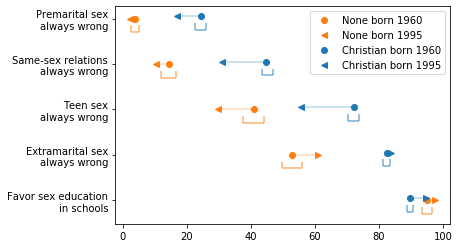

In [78]:
varnames = ['premarsx', 'homosex', 'teensex', 'xmarsex', 'sexeduc']
multiplot(results, varnames, loc='upper right')

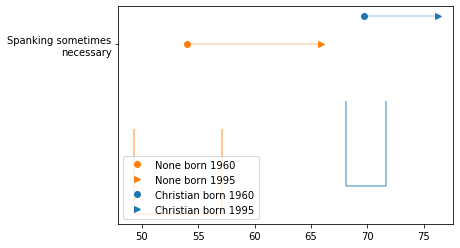

In [59]:
varnames = ['spanking']
multiplot(results, varnames)

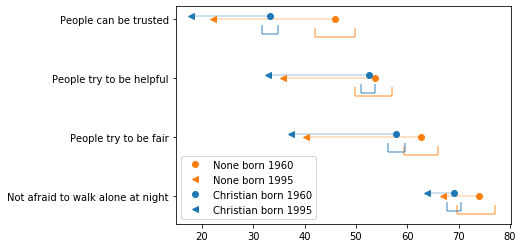

In [60]:
varnames = ['trust', 'helpful', 'fair', 'fear']
multiplot(results, varnames)

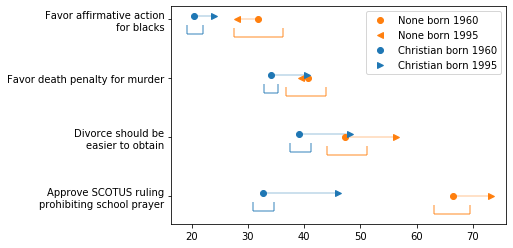

In [79]:
varnames = ['affrmact', 'cappun', 'divlaw', 'prayer']
multiplot(results, varnames, loc='upper right')

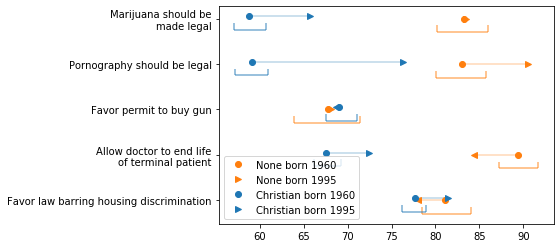

In [62]:
varnames = ['grass', 'pornlaw', 'gunlaw', 'letdie1', 'racopen']
multiplot(results, varnames)